In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
import cv2 as cv
import os
import DarkArtefactRemoval as dca
import dullrazor as dr
import segmentation_and_preprocessing as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

2024-04-25 10:23:48.918538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading Data

In [5]:
# Répertoire contenant les images
image_dir_train = 'Train/Train/'
image_dir_test = 'Test/Test/'

Train_path = image_dir_train

import glob
images_train = glob.glob(Train_path + '/*[0-9].jpg')
mask_img_train = glob.glob(Train_path + '/*seg.png')

images_with_mask = [ Train_path + mask_img_train[i].split('/')[-1].split('_seg')[0] + '.jpg' for i in range(len(mask_img_train))]
images_test = glob.glob(image_dir_test + '/*[0-9].jpg')
mask_img_test = glob.glob(image_dir_test + '/*seg.png')

#Lire le csv metadataTrain et metadataTest
metadataTrain = pd.read_csv('metadataTrain.csv')
metadataTest = pd.read_csv('metadataTest.csv')



In [6]:
# Checking if the number of images is right 
print('There are', len(images_train),  'train images')
print('There are', len(images_with_mask),  'train images with mask')
print('There are', len(mask_img_train),  'train masks')
print('There are', len(images_test),  'test images')
print('There are', len(mask_img_test),  'test masks')

There are 18998 train images
There are 1945 train images with mask
There are 1945 train masks
There are 6333 test images
There are 648 test masks


### Compute the segmentation mask for all the 20 000 images of the training set

In [4]:
sp.compute_and_save_segmented_lesions(images_train[:len(images_train)//2], 'output_masks_train_set_1')

  1%|          | 105/9499 [00:20<29:52,  5.24it/s] 


KeyboardInterrupt: 

In [ ]:
sp.compute_and_save_segmented_lesions(images_train[len(images_train)//2:], 'output_masks_train_set_1')

: 

In [7]:
images_train_mask = glob.glob('output_masks_train_set_1' + '/*.png')
print(len(images_train_mask))

18998


# CNN

### Préparation des données

- Images carrées de 256x256
- Normalisation des images
- Augmentation des données

### Prepare data for CNN

In [8]:
X_train = glob.glob('output_masks_train_set_1/*.png')
X_train_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in X_train]

# Get the names and classes as pandas Series
names_series = metadataTrain["ID"].loc[metadataTrain["ID"].isin(X_train_names)]
classes_series = metadataTrain["CLASS"].loc[metadataTrain["ID"].isin(X_train_names)]

# Convert the pandas Series to lists
names_list = names_series.tolist()
classes_list = classes_series.tolist()

X_train_ordered = []
X_train_ordered_names = []
for i in range(0, len(names_list)):
    for j in range(0, len(X_train_names)):
        if names_list[i] in X_train_names[j]:
            X_train_ordered.append(X_train[j])
            X_train_ordered_names.append(X_train_names[j])

##### Train test split

In [9]:
X_train = [io.imread(x) for x in X_train_ordered]
X_train = np.array(X_train)
y_train = classes_list
y_train = np.array(y_train)
#----------------------------------
y_train = y_train - 1
#----------------------------------
print(X_train.shape)
print(y_train.shape)

#Créer la validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=50)

(18998, 256, 256, 3)
(18998,)


# ATTENTION Y_train entre 1 et 8

# Modification j'ajoute -1 pour le passer entre 0 et 7 pour le CNN

# Ne pas oubliez de faire la démarche inverse après la prédiction

In [10]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Définir les transformations à appliquer aux images d'entraînement
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Créer le jeu de données de segmentation
train_dataset = SegmentationDataset(X_train, y_train, transform=transform)



In [13]:
learning_rate = 0.01
n_epochs = 25
batch_size = 256
nb_classes = 8

nb_filters = 32         # number of convolutional filters to use
kernel_size = (3, 3)    # convolution kernel size
pool_size = (2, 2)      # size of pooling area for max pooling

# --- Size of the successive layers
n_h_0 = nb_channels = 3 #3 channels for RGB
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters
n_h_4 = nb_filters
n_h_5 = nb_filters
n_h_6 = nb_filters


model = torch.nn.Sequential(nn.Conv2d(in_channels=n_h_0, out_channels=n_h_1, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=n_h_1, out_channels=n_h_2, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_2, out_channels=n_h_3, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_3, out_channels=n_h_4, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_4, out_channels=n_h_5, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_5, out_channels=n_h_6, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            
                            nn.Flatten(),
                            nn.Linear(in_features = int(n_h_6 * 8* 8) , out_features = nb_classes))



train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


device = torch.device("cuda:1" if torch.cuda.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
print('device',device)
model = model.to(device)

device cuda:1


In [11]:
def cnn_accuracy(predict,labels):
  accuracy = (predict == labels).sum()/(labels.shape[0])
  return accuracy

def vector_to_class(x):
  y = torch.argmax(nn.Softmax(dim=1)(x),axis=1)
  return y

In [14]:
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader)):

    # pass the samples through the network
    predict = model.forward(imgs.to(device))
    # apply loss function
    loss = criterion(predict, labels.to(device))
    # set the gradients back to 0
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # parameter update
    optimizer.step()
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

    if epoch % 1 == 0:
      torch.save(model.state_dict(), 'model_save/modele_epoch_{}.pth'.format(epoch))

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(train_loader.dataset)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


Epoch:0 Train Loss:0.0061
Accuracy:0.4882


100%|██████████| 60/60 [00:38<00:00,  1.55it/s]


Epoch:1 Train Loss:0.0058
Accuracy:0.5071


100%|██████████| 60/60 [00:32<00:00,  1.87it/s]


Epoch:2 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:48<00:00,  1.25it/s]


Epoch:3 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:30<00:00,  1.97it/s]


Epoch:4 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:29<00:00,  2.01it/s]


Epoch:5 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch:6 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:26<00:00,  2.27it/s]


Epoch:7 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


Epoch:8 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:22<00:00,  2.71it/s]


Epoch:9 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:24<00:00,  2.41it/s]


Epoch:10 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


Epoch:11 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


Epoch:12 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:23<00:00,  2.57it/s]


Epoch:13 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Epoch:14 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:22<00:00,  2.66it/s]


Epoch:15 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.98it/s]


Epoch:16 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.99it/s]


Epoch:17 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


Epoch:18 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.99it/s]


Epoch:19 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch:20 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:28<00:00,  2.09it/s]


Epoch:21 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:19<00:00,  3.05it/s]


Epoch:22 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Epoch:23 Train Loss:0.0057
Accuracy:0.5071


100%|██████████| 60/60 [00:20<00:00,  2.92it/s]

Epoch:24 Train Loss:0.0057
Accuracy:0.5071


### Heatmap

device cpu
[1 1 1 ... 1 1 1]


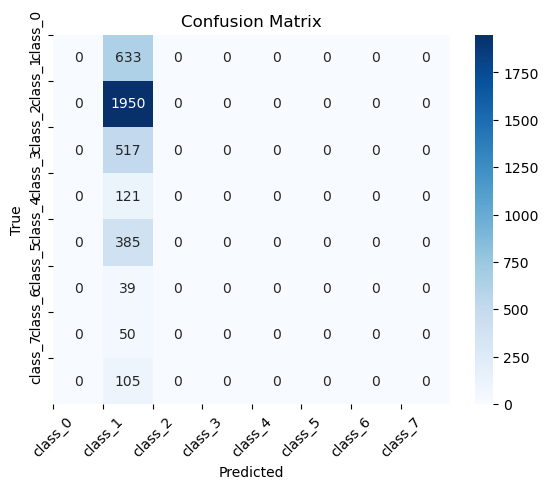

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Predict the classes for the validation set

# Définir les transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Appliquer les transformations à X_val
X_val_transformed = [transform(img) for img in X_val]
X_val_transformed = torch.stack(X_val_transformed)

#load the model
model.load_state_dict(torch.load('/home/infres/kaeppelin-22/Git/Projet-IMA205/model_save/modele_epoch_24.pth'))
#device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print('device',device)
model = model.to(device)

# Prédire les classes pour le jeu de validation
y_pred = model(X_val_transformed.to(device))
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.numpy()

print(y_pred)


# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap from the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')

# Labels, title and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(range(8))
plt.yticks(range(8))

# Add class names to the x and y axis labels
class_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7'] # replace with your class names
plt.xticks(range(8), class_names, rotation=45)
plt.yticks(range(8), class_names)

plt.show()


## Préparation de la detection

### Prepare data for predicting the test set

In [ ]:
X_test = glob.glob('output_masks_test_set/*.png')
X_test_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in X_test]

X_test = [io.imread(x) for x in X_test]
X_test = np.array(X_test)
print(X_test.shape)

: 

In [ ]:
predicted_classes = model.predict(X_test)

: 

In [ ]:
print(predicted_classes.shape)
print(predicted_classes)

predicted_classes_final = [np.argmax(predicted_classes[i]) for i in range(0, len(predicted_classes))]

print(predicted_classes_final)

: 

Ecrire les résultats predicted class dans un fichier csv de 2 colonnes avec 1 colonne avec le nom correspondant à la classe et 1 colonne correspondant à la classe prédite. Le séparateur est une virgule

In [ ]:
# Open the CSV file for writing
with open('SampleSubmission2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    writer.writerow(['ID', 'CLASS'])

    # Write the predicted classes and image filenames to the CSV file
    for i in range(len(predicted_classes)):
        writer.writerow([X_test_names[i], predicted_classes_final[i]])

: 

: 